In [117]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [56]:
spark = SparkSession.builder.appName('session-01').getOrCreate()
spark

In [57]:
df = spark.read.csv('../data/bank.csv', 
                    header=True,
                    inferSchema=True)
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [58]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [59]:
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [60]:
df.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [61]:
numerical_features = [dt[0] for dt in df.dtypes if dt[1] == 'int']
numerical_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [62]:
df.select(numerical_features).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


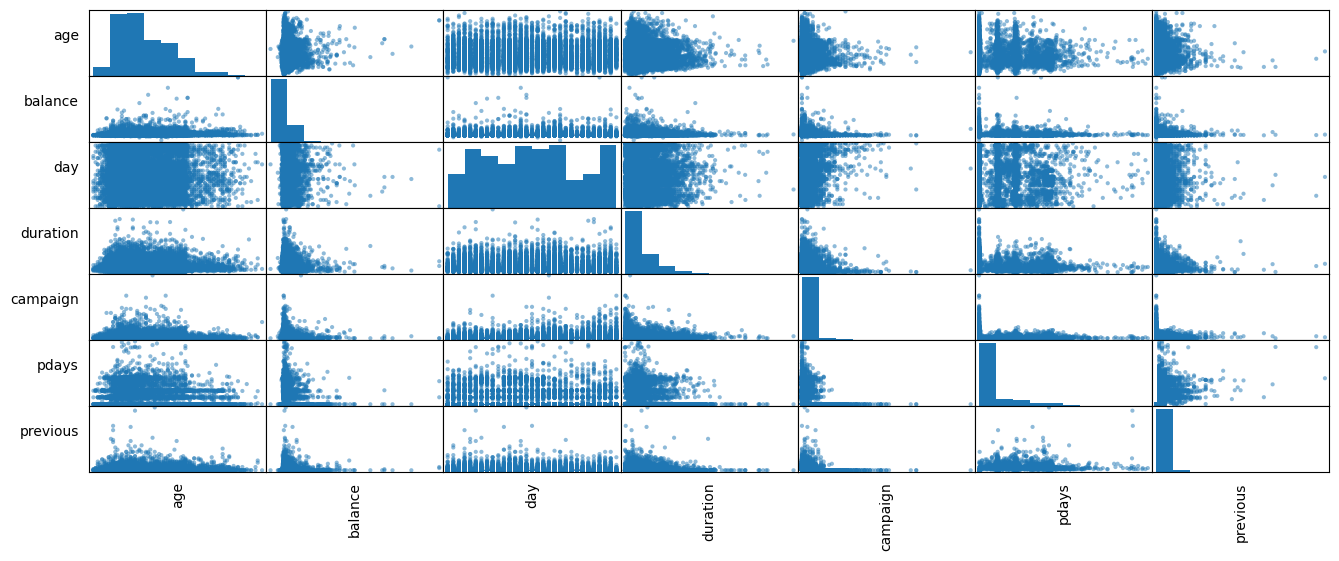

In [63]:
numeric_data = df.select(numerical_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(16, 6))
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [64]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [65]:
df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
features = df.columns

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [66]:
numerical_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [67]:
categorical_features = []

for feature in features:
    if feature not in numerical_features:
        categorical_features.append(feature)
        
categorical_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [68]:
stages = []

for feature in categorical_features:
    stringIndexer = StringIndexer(inputCol=feature,
                                  outputCol=feature+'Index')
    ohe_encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],
                                outputCols=[feature+'classVec'])
    
    stages += [stringIndexer, ohe_encoder]

In [69]:
labelStringIndexer = StringIndexer(inputCol='deposit',
                                   outputCol='label')

stages += [labelStringIndexer]

assemblerInputs = [feature + 'classVec' for feature in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, 
                            outputCol='features')

stages += [assembler]

In [70]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selected_features = ['label', 'features'] + features

df = df.select(selected_features)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [71]:
# df.select(selected_features).toPandas()

In [73]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [76]:
train.count(), test.count()

(8998, 2164)

## Logistic Regression Model

In [86]:
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        maxIter=20)
lrModel = lr.fit(train)

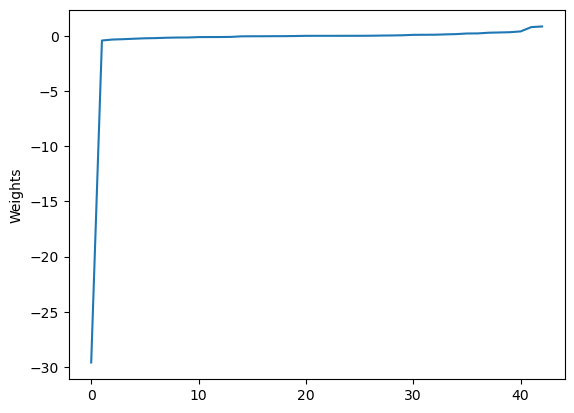

In [87]:
weights = np.sort(lrModel.coefficients)

plt.plot(weights)
plt.ylabel('Weights')
plt.show()

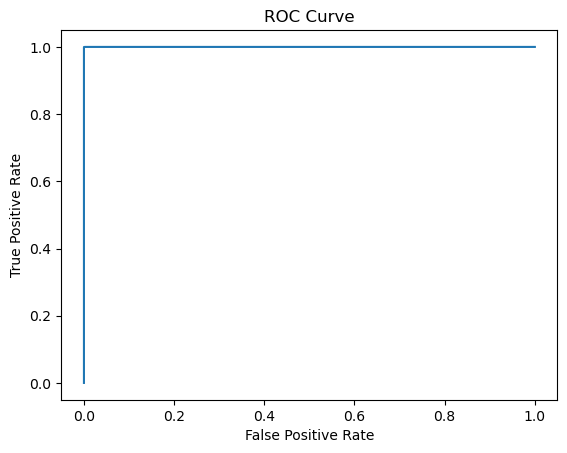

Training set AUC = 0.9999998265480672


In [88]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'], roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(f'Training set AUC = {trainingSummary.areaUnderROC}')

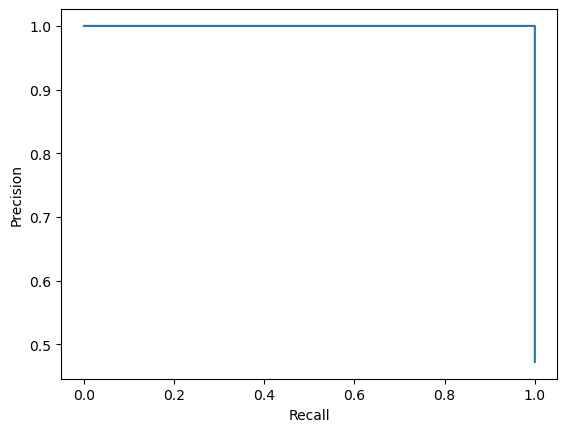

In [89]:
pr = trainingSummary.pr.toPandas()

plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [98]:
predictions = lrModel.transform(test)
# predictions.toPandas()

In [107]:
evaluator = BinaryClassificationEvaluator()
print(f"Test AUC = {evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})}")

Test AUC = 1.0


## Decision Tree Classifier

In [104]:
dt = DecisionTreeClassifier(featuresCol='features',
                            labelCol='label',  
                            maxDepth=10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [106]:
evaluator = BinaryClassificationEvaluator()
print(f"Test AUC: {evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})}")

Test AUC: 1.0


## Random Forest Classifier

In [109]:
rf = RandomForestClassifier(featuresCol='features',
                            labelCol='label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [110]:
evaluator = BinaryClassificationEvaluator()
print(f"Test AUC = {evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})}")

Test AUC = 1.0


## Gradient-Boosted Tree Classifier

In [112]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

In [113]:
evaluator = BinaryClassificationEvaluator()
print(f"Test AUC = {evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})}")

Test AUC = 1.0


In [116]:
gbt.explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)

In [121]:
paramGrid = (
    ParamGridBuilder()
        .addGrid(gbt.maxDepth, [2, 4, 6])
        .addGrid(gbt.maxBins, [20, 60])
        .addGrid(gbt.maxIter, [10, 20])
        .build()
)

cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions, 
                   {evaluator.metricName: 'areaUnderROC'})

1.0